### Unsupervised learning

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import shutil

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from PIL import Image

In [2]:
import seaborn as sns

sns.set_theme()
sns.set_context("paper", rc={"lines.linewidth": 2.5})

In [3]:
# Utility functions
def get_season(date):
    """
    Get the season for a given date.

    Parameters:
    - date: datetime object

    Returns:
    - season: str
    """
    if pd.isnull(date):
        return None
    
    month = date.month

    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    
def get_time_of_day(date):
    """
    Determines if it's night or not (0, 1)

    Parameters:
    - date: datetime object

    Returns:
    - night: float
    """
    if pd.isnull(date):
        return 0

    hour = date.hour

    day_threshold = 6 

    if hour < day_threshold:
        return 0  # Night
    else:
        return 1  # Day
  
def temperature_label(temperature):
    """
    Get temperature range for a given temperature.

    Parameters:
    - temperature: float

    Returns:
    - temperature_label: str
    """
    if pd.isnull(temperature):
        return None
    
    if temperature < -10:
        return "Extremely Cold"
    elif -10 <= temperature < 0:
        return "Cold"
    elif 0 <= temperature < 5:
        return "Cool"
    elif 5 <= temperature < 10:
        return "Slightly Warm"
    elif 10 <= temperature < 15:
        return "Moderate"
    elif 15 <= temperature < 20:
        return "Warm"
    elif 20 <= temperature < 25:
        return "Very Warm"
    elif 25 <= temperature < 30:
        return "Hot"
    elif 30 <= temperature < 35:
        return "Very Hot"
    elif 35 <= temperature < 40:
        return "Extremely Hot"
    else:
        return "Exceptionally Hot"
    
def classify_animal(animal):
    groups = {
        # Mammals
        # "mammal": ["porcupine", "wild boar", "marten", "badger", "fox", "wolf", "dog", "cat", "hare", "deer", "horse", "squirrel"],
        
        # Birds
        "bird": ["buzzard", "heron", "mallard"],
        
        # Water animals
        "water_animal": ["mallard", "heron"],
        
        # Predatory animals
        "predatory_animal": ["fox", "wolf", "buzzard"],
        
        # Domestic animals
        "domestic_animal": ["dog", "cat", "horse"],
        
        # Herbivores
        "herbivore": ["porcupine", "wild boar", "hare", "deer", "horse", "squirrel"],
        
        # Night Animals
        "night_animal": ["fox", "wolf", "hare", "badger"],
        
        # Size Classification
        "size": ["xs", "s", "m", "l"]
    }
    
    # Define size boundaries
    size_boundaries = {
        "xs": ["mallard", "buzzard", "porcupine", "marten", "cat", "hare", "squirrel"],
        "s": ["fox", "cat", "badger"],
        "m": ["heron", "dog", "wild boar","deer", "wolf"],
        "l": ["horse"]
    }
    
     # Classify based on size
    size_group = next((size for size, animals in size_boundaries.items() if animal.lower() in animals), None)
    
    # Classify based on other groups
    animal_groups = {group: 1 if animal.lower() in animals else 0 for group, animals in groups.items()}
    
    # Add size group to the result
    animal_groups["size"] = size_group
    
    return animal_groups

In [4]:
# define the direcories
images_dir = './images/aculei-images'
csv_dir = './datasets'

In [5]:
# import the dataset
df = pd.read_pickle(csv_dir + '/animals.pkl')

In [6]:
df.head()

image_name  camera            date_time        date  \
0   TF_ACULEI_8040_DSCF0129.jpg     1.0  2021-07-22 23:04:07  2021-07-22   
1    TF_ACULEI_900_DSCF0756.jpg     1.0  2021-05-27 22:01:44  2021-05-27   
2  TF_ACULEI_15294_DSCF0133.jpg     6.0  2023-03-30 20:35:58  2023-03-30   
3  TF_ACULEI_11374_DSCF0064.jpg     6.0  2022-06-09 21:29:59  2022-06-09   
4   TF_ACULEI_4106_DSCF4336.jpg     1.0  2021-06-16 23:41:09  2021-06-16   

       time            moon  temp  \
0  23:04:07       Full Moon  25.0   
1  22:01:44       Full Moon  16.0   
2  20:35:58   First Quarter   9.0   
3  21:29:59  Waxing Gibbous  15.0   
4  23:41:09   First Quarter  19.0   

                                             sha-256     label1     label2  \
0  00917733a6aa7e574a2da861dc75b70f5e38db45b50983...  wild boar        NaN   
1  01b46bf7f72f5ecd35669d876892619192c50771d44949...  wild boar        NaN   
2  a4080d64cc86785ee8ab82468db78b14e4ddb9838faef6...  porcupine     badger   
3  314a99154f1709a8a6ac99069b1af4cebf0cc9df089ce4...        fox  porcupine   
4  f1c6a3c629f9fb55975f6e02eeeccbd708477ddcf574e5...        fox       None   

      label3  
0        NaN  
1        NaN  
2        fox  
3  wild boar  
4       None

In [7]:
# some type changes
df['date'] = pd.to_datetime(df['date'])
df['date_time'] = pd.to_datetime(df['date_time'])

In [8]:
# # remove outliers ? 
# df['month'] = df['date'].dt.to_period('M')
# df = df[df['month'] != '2021-06'].copy()
# df = df[df['month'] != '2021-05'].copy()
# df = df[df['month'] != '2021-07'].copy()
# df = df[df['month'] != '2023-01'].copy()
# df.drop(columns=['month'], inplace=True)

In [9]:
# adding some new columns
df['season'] = df['date_time'].apply(get_season)
df['night'] = df['date_time'].apply(get_time_of_day)
df['temp'] = df['temp'].apply(temperature_label)


In [10]:
# Apply the function to the 'label' column and store the result in new columns
df_result = pd.DataFrame(df['label1'].apply(classify_animal).tolist())

# Concatenate the result with the original DataFrame
df = pd.concat([df, df_result], axis=1)

# Display the updated DataFrame
df.head()


image_name  camera           date_time       date  \
0   TF_ACULEI_8040_DSCF0129.jpg     1.0 2021-07-22 23:04:07 2021-07-22   
1    TF_ACULEI_900_DSCF0756.jpg     1.0 2021-05-27 22:01:44 2021-05-27   
2  TF_ACULEI_15294_DSCF0133.jpg     6.0 2023-03-30 20:35:58 2023-03-30   
3  TF_ACULEI_11374_DSCF0064.jpg     6.0 2022-06-09 21:29:59 2022-06-09   
4   TF_ACULEI_4106_DSCF4336.jpg     1.0 2021-06-16 23:41:09 2021-06-16   

       time            moon           temp  \
0  23:04:07       Full Moon            Hot   
1  22:01:44       Full Moon           Warm   
2  20:35:58   First Quarter  Slightly Warm   
3  21:29:59  Waxing Gibbous           Warm   
4  23:41:09   First Quarter           Warm   

                                             sha-256     label1     label2  \
0  00917733a6aa7e574a2da861dc75b70f5e38db45b50983...  wild boar        NaN   
1  01b46bf7f72f5ecd35669d876892619192c50771d44949...  wild boar        NaN   
2  a4080d64cc86785ee8ab82468db78b14e4ddb9838faef6...  porcupine     badger   
3  314a99154f1709a8a6ac99069b1af4cebf0cc9df089ce4...        fox  porcupine   
4  f1c6a3c629f9fb55975f6e02eeeccbd708477ddcf574e5...        fox       None   

      label3  season  night  bird  water_animal  predatory_animal  \
0        NaN  Summer      1     0             0                 0   
1        NaN  Spring      1     0             0                 0   
2        fox  Spring      1     0             0                 0   
3  wild boar  Summer      1     0             0                 1   
4       None  Summer      1     0             0                 1   

   domestic_animal  herbivore  night_animal size  
0                0          1             0    m  
1                0          1             0    m  
2                0          1             0   xs  
3                0          0             1    s  
4                0          0             1    s

In [11]:
# now define whic columns have to be encoded and which ones are not useful
cols_to_encode = ['label1', 'season', 'temp', 'size', 'bird', 'water_animal', 'predatory_animal', 'domestic_animal', 'herbivore', 'night_animal']
cols_to_drop = ['image_name', 'date_time', 'date', 'time', 'sha-256', 'label2', 'label3', 'camera', 'moon']

df.drop(columns=cols_to_drop, inplace=True)
encoded_df = pd.get_dummies(df, columns=cols_to_encode, prefix=cols_to_encode)
encoded_df.head()

night  label1_badger  label1_buzzard  label1_cat  label1_deer  label1_fox  \
0      1              0               0           0            0           0   
1      1              0               0           0            0           0   
2      1              0               0           0            0           0   
3      1              0               0           0            0           1   
4      1              0               0           0            0           1   

   label1_hare  label1_heron  label1_horse  label1_mallard  ...  \
0            0             0             0               0  ...   
1            0             0             0               0  ...   
2            0             0             0               0  ...   
3            0             0             0               0  ...   
4            0             0             0               0  ...   

   water_animal_0  water_animal_1  predatory_animal_0  predatory_animal_1  \
0               1               0                   1                   0   
1               1               0                   1                   0   
2               1               0                   1                   0   
3               1               0                   0                   1   
4               1               0                   0                   1   

   domestic_animal_0  domestic_animal_1  herbivore_0  herbivore_1  \
0                  1                  0            0            1   
1                  1                  0            0            1   
2                  1                  0            0            1   
3                  1                  0            1            0   
4                  1                  0            1            0   

   night_animal_0  night_animal_1  
0               1               0  
1               1               0  
2               1               0  
3               0               1  
4               0               1  

[5 rows x 44 columns]

In [12]:
encoded_df.shape

(16874, 44)

### PCA (Principal component analysis)

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the original features into a new set of uncorrelated features, called principal components. These components are ordered by the amount of variance they explain.

- **Explained variance ratio**: The explained variance ratio tells you the proportion of variance explained by each principal component. It helps you understand how much information is retained by each component. To access it: `pca.explained_variance_ratio_` after fitting the PCA model

- **Scree Plot**: A scree plot is a line plot of the explained variance of each principal component. It helps decide how many principal components to retain. 

- **Individual Component Contribution**: Understand the contribution of each original feature to each principal component by examining the PCA components. These are accessible using `pca.components_`. The components are scaled so that the sum of squares is 1, and their signs are arbitrary. The magnitude of the component coefficients indicates the importance of the corresponding features.

In [13]:
scaler = StandardScaler()

# Extract features
features = encoded_df

# Standardize the features
features_standardized = scaler.fit_transform(features)

In [14]:
# Perform pca analyzing all features
pca = PCA(n_components=features.shape[1])
principal_components = pca.fit_transform(features_standardized)

In [15]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [1.93789941e-01 1.31379414e-01 9.81870631e-02 6.39681555e-02
 4.22762704e-02 3.55564183e-02 3.10132129e-02 3.04109349e-02
 2.82064771e-02 2.68545926e-02 2.60589828e-02 2.51863786e-02
 2.47594041e-02 2.41439937e-02 2.32317317e-02 2.30687932e-02
 2.28839977e-02 2.27313732e-02 2.24023779e-02 2.21945568e-02
 2.11740650e-02 1.94374147e-02 1.63851052e-02 1.43160376e-02
 7.31683199e-03 3.04096989e-03 2.55059294e-05 8.27991036e-28
 3.14886737e-28 2.69010625e-28 1.07323873e-28 7.01750457e-29
 6.38624327e-29 3.04764815e-29 1.40453707e-29 1.26845215e-29
 7.48174480e-30 2.12353500e-31 1.01832069e-33 1.01832069e-33
 1.01832069e-33 1.01832069e-33 1.01832069e-33 1.01832069e-33]


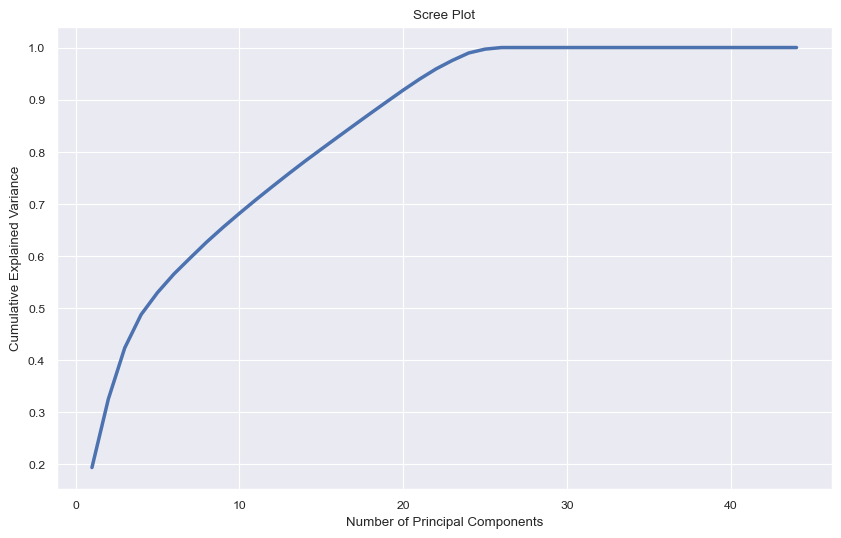

In [16]:
# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio))
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

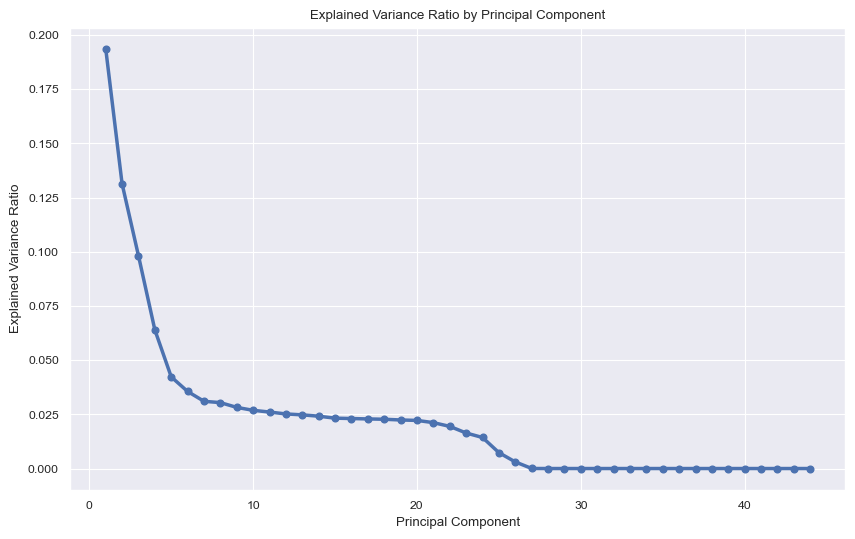

In [17]:
# Plotting the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [18]:
# Individual components contributions
components = pca.components_
print("Principal Components:")
print(components)

Principal Components:
[[ 4.13247234e-02  7.07072946e-02  3.20034821e-02 ... -3.21756256e-01
  -3.00560498e-01  3.00560498e-01]
 [ 8.39078033e-02 -1.60653167e-02  5.28510147e-02 ... -3.15039539e-02
   1.58227519e-01 -1.58227519e-01]
 [ 2.43041353e-02 -4.95107544e-05 -6.02146536e-03 ...  4.37414296e-02
   2.52575005e-02 -2.52575005e-02]
 ...
 [-0.00000000e+00 -3.32688403e-17 -1.41921180e-16 ... -4.64384696e-01
   6.51847825e-14  6.53302824e-14]
 [ 0.00000000e+00  1.00704590e-16 -3.92615478e-17 ... -5.31279538e-01
   6.67806535e-15  6.49715606e-15]
 [ 0.00000000e+00 -1.49156211e-16  4.44351057e-17 ... -4.56989965e-02
  -6.32195475e-14 -6.31891424e-14]]


In [19]:
# Set a threshold for cumulative explained variance
threshold = 0.95

# Find the number of components that meet the threshold
num_components = np.argmax(np.cumsum(explained_variance_ratio) >= threshold) + 1

print(f"Number of components to retain for {threshold * 100}% cumulative explained variance: {num_components}")

# Then use this number when applying PCA
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(features_standardized)


Number of components to retain for 95.0% cumulative explained variance: 22


In [20]:
loadings = pca.components_

# Display the loadings in a DataFrame for better readability
loadings_df = pd.DataFrame(loadings, columns=encoded_df.columns)

# Show the loadings for the first few principal components
print("Loadings for the first few principal components:")
loadings_df.head(10)

Loadings for the first few principal components:


night  label1_badger  label1_buzzard  label1_cat  label1_deer  \
0  0.041325       0.070707        0.032003    0.003629    -0.031094   
1  0.083908      -0.016065        0.052851    0.005614     0.006374   
2  0.024304      -0.000050       -0.006021    0.042785     0.009658   
3 -0.095228      -0.042303       -0.002994   -0.002168    -0.102393   
4  0.229350       0.047098       -0.016474   -0.033566     0.321133   
5 -0.112018      -0.432822        0.221159   -0.001453    -0.057511   
6 -0.107292      -0.026827        0.077166    0.040897     0.020397   
7 -0.113548       0.300226       -0.082432    0.043192    -0.384590   
8  0.462614      -0.089306        0.321061    0.057666     0.022433   
9  0.173031      -0.109649        0.050225   -0.091295    -0.328575   

   label1_fox  label1_hare  label1_heron  label1_horse  label1_mallard  ...  \
0    0.289810     0.024640      0.037867     -0.016320        0.076739  ...   
1   -0.167019     0.004941      0.195734      0.013405        0.319775  ...   
2   -0.032775     0.016121     -0.041924      0.463073       -0.035617  ...   
3    0.110451    -0.154650      0.151970      0.142712        0.067366  ...   
4    0.000450    -0.123023      0.138068     -0.015876       -0.065751  ...   
5    0.124159    -0.244760      0.087949     -0.002986       -0.001221  ...   
6   -0.003437    -0.201185     -0.039846     -0.007503       -0.008672  ...   
7   -0.079507    -0.188585      0.003512      0.031251       -0.002298  ...   
8   -0.007391    -0.138792     -0.043600      0.008542       -0.087077  ...   
9    0.043706     0.369713     -0.007097      0.033188        0.041028  ...   

   water_animal_0  water_animal_1  predatory_animal_0  predatory_animal_1  \
0       -0.085305        0.085305           -0.293140            0.293140   
1       -0.377207        0.377207            0.157182           -0.157182   
2        0.053543       -0.053543            0.033815           -0.033815   
3       -0.142907        0.142907           -0.109872            0.109872   
4       -0.024598        0.024598            0.000872           -0.000872   
5       -0.049375        0.049375           -0.159739            0.159739   
6        0.030017       -0.030017           -0.012894            0.012894   
7       -0.000107        0.000107            0.098908           -0.098908   
8        0.097159       -0.097159           -0.045649            0.045649   
9       -0.029943        0.029943           -0.044052            0.044052   

   domestic_animal_0  domestic_animal_1  herbivore_0  herbivore_1  \
0           0.015654          -0.015654     0.321756    -0.321756   
1          -0.014072           0.014072     0.031504    -0.031504   
2          -0.464755           0.464755    -0.043741     0.043741   
3          -0.141062           0.141062     0.074104    -0.074104   
4           0.020466          -0.020466    -0.009727     0.009727   
5           0.003163          -0.003163     0.028036    -0.028036   
6           0.001657          -0.001657     0.089488    -0.089488   
7          -0.037056           0.037056     0.167118    -0.167118   
8          -0.016605           0.016605     0.083242    -0.083242   
9          -0.019983           0.019983    -0.134545     0.134545   

   night_animal_0  night_animal_1  
0       -0.300560        0.300560  
1        0.158228       -0.158228  
2        0.025258       -0.025258  
3       -0.037159        0.037159  
4        0.021286       -0.021286  
5        0.120243       -0.120243  
6        0.074768       -0.074768  
7        0.032691       -0.032691  
8        0.084079       -0.084079  
9       -0.113758        0.113758  

[10 rows x 44 columns]

In [21]:
print(principal_components)

[[-2.00662247 -0.2310031  -0.68974407 ...  0.15106773  0.5949382
   0.30284438]
 [-1.61975139 -0.15711663 -0.37734241 ... -0.57320678  0.01656432
  -0.31914638]
 [-0.14643018  0.80310167  0.79500361 ... -1.61453931  0.4815194
  -1.41818551]
 ...
 [-2.08889091 -0.3087975  -0.75199798 ... -0.04938301 -0.04953065
  -0.24494851]
 [-2.17182712 -0.47719537 -0.8007749  ...  0.02089681 -0.02490302
  -0.1467202 ]
 [-1.85912372 -0.14664474 -0.57201876 ... -2.68194001  8.51393205
   5.72380403]]


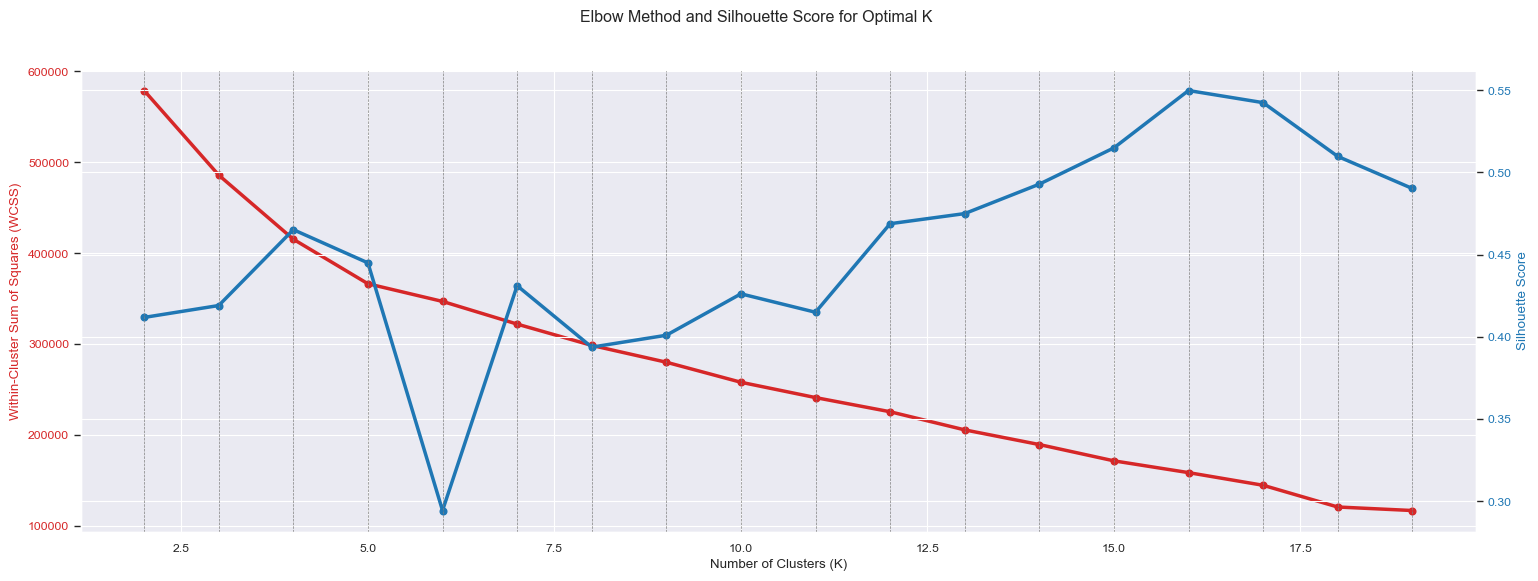

In [22]:
# Calculate the within-cluster sum of squares (WCSS) for different values of K
k_threshold = 20

wcss = []
silhouette_scores = []

for k in range(2, k_threshold):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(principal_components)
    wcss.append(kmeans.inertia_)
    
    if k > 1:
        silhouette_scores.append(silhouette_score(principal_components, cluster_labels))

# Plotting both Elbow Method and Silhouette Score
fig, ax1 = plt.subplots(figsize=(18, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)', color=color)
ax1.plot(range(2, k_threshold), wcss, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, k_threshold), silhouette_scores, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

for i, k in enumerate(range(2, k_threshold)):
    plt.axvline(x=k, linestyle='--', color='gray', linewidth=0.5)

fig.suptitle('Elbow Method and Silhouette Score for Optimal K')
plt.show()


In [23]:
# defining the model and the K
K = 6
model = KMeans(n_clusters=K)

# fitting data
model.fit(encoded_df)

# predictions
all_predictions = model.predict(encoded_df)

# adding the results to the df cluster
encoded_df['cluster'] = all_predictions

In [24]:
model.cluster_centers_

array([[ 5.84466019e-01, -7.63278329e-17, -2.16840434e-18,
         2.60208521e-18,  2.68932039e-01,  1.38777878e-15,
         4.85722573e-17, -3.98986399e-17,  1.61488673e-01,
         1.04083409e-17, -2.08166817e-17, -6.93889390e-16,
         1.95156391e-17,  5.69579288e-01, -4.98732999e-18,
         2.80258900e-01,  3.82200647e-01,  6.95792880e-02,
         2.66666667e-01,  1.94174757e-03,  1.15533981e-01,
         2.71050543e-19,  9.38511327e-03,  2.75404531e-01,
         1.44983819e-01,  1.94174757e-03,  1.10032362e-02,
         2.39482201e-02,  1.61488673e-01,  8.38511327e-01,
        -4.16333634e-16,  4.16333634e-16,  1.00000000e+00,
         1.87350135e-16,  1.00000000e+00,  1.59594560e-16,
         1.00000000e+00,  9.43689571e-16,  8.38511327e-01,
         1.61488673e-01,  9.71445147e-16,  1.00000000e+00,
         1.00000000e+00, -6.66133815e-16],
       [ 2.43332417e-01, -7.97972799e-17, -2.16840434e-18,
         2.71050543e-18,  1.04481716e-02,  9.99200722e-16,
         3.46

In [25]:
encoded_df.head()

night  label1_badger  label1_buzzard  label1_cat  label1_deer  label1_fox  \
0      1              0               0           0            0           0   
1      1              0               0           0            0           0   
2      1              0               0           0            0           0   
3      1              0               0           0            0           1   
4      1              0               0           0            0           1   

   label1_hare  label1_heron  label1_horse  label1_mallard  ...  \
0            0             0             0               0  ...   
1            0             0             0               0  ...   
2            0             0             0               0  ...   
3            0             0             0               0  ...   
4            0             0             0               0  ...   

   water_animal_1  predatory_animal_0  predatory_animal_1  domestic_animal_0  \
0               0                   1                   0                  1   
1               0                   1                   0                  1   
2               0                   1                   0                  1   
3               0                   0                   1                  1   
4               0                   0                   1                  1   

   domestic_animal_1  herbivore_0  herbivore_1  night_animal_0  \
0                  0            0            1               1   
1                  0            0            1               1   
2                  0            0            1               1   
3                  0            1            0               0   
4                  0            1            0               0   

   night_animal_1  cluster  
0               0        3  
1               0        3  
2               0        5  
3               1        2  
4               1        2  

[5 rows x 45 columns]

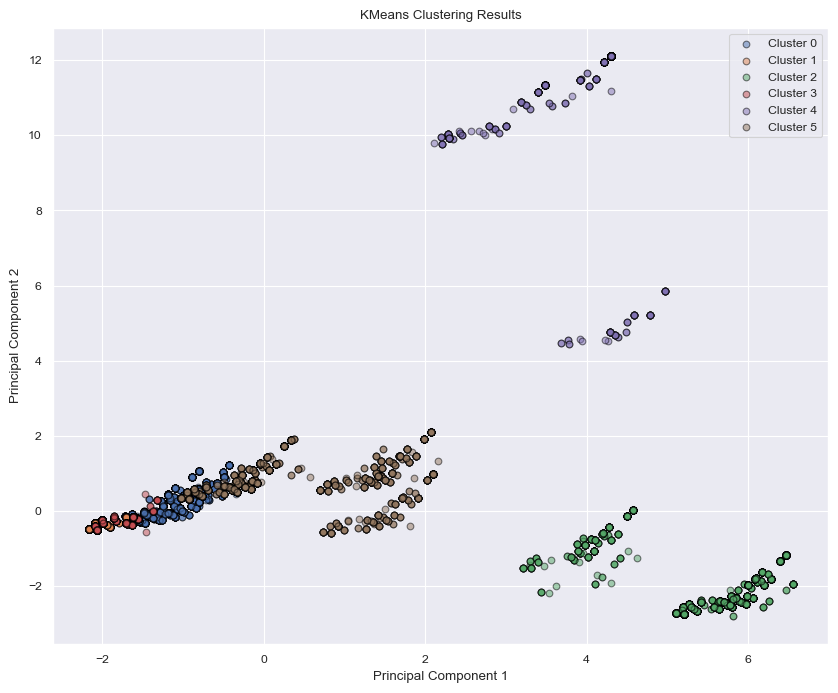

In [26]:
features = encoded_df.drop('cluster', axis=1)

# Perform PCA to reduce dimensionality to 2 components
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_standardized)

# Add the 'cluster' column to the reduced DataFrame
reduced_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
reduced_df['cluster'] = encoded_df['cluster']

# Plotting the results
plt.figure(figsize=(10, 8))
for cluster in range(K):
    cluster_points = reduced_df[reduced_df['cluster'] == cluster]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster}', ec='black', alpha=0.5)

plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

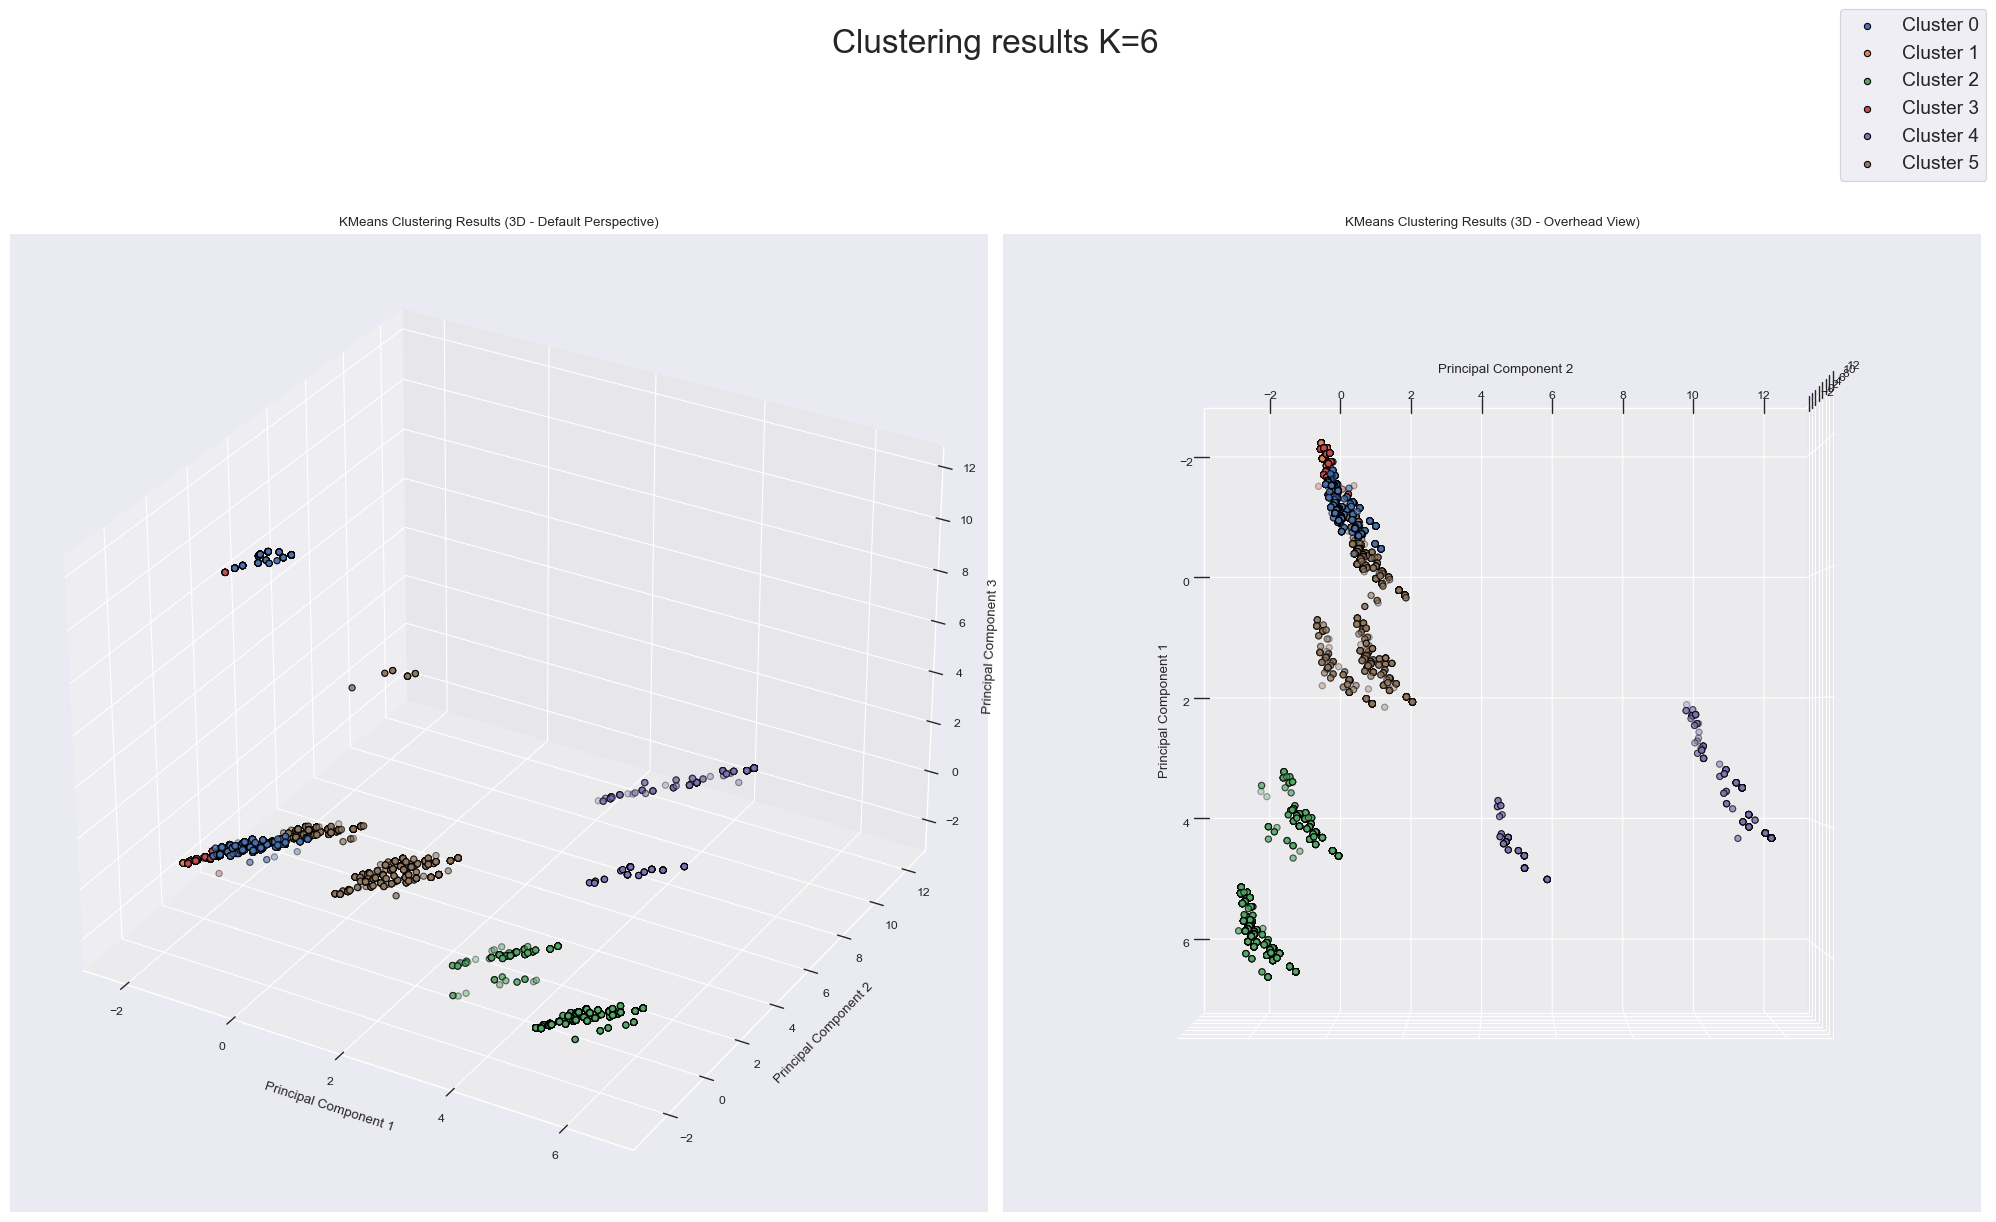

In [34]:
# Extract features
features = encoded_df.drop('cluster', axis=1)

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Perform PCA to reduce dimensionality to 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(features_standardized)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 4)])

# Add the 'cluster' column to the reduced DataFrame
pc_df['cluster'] = encoded_df['cluster']

# Plotting the results in 3D with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 14), subplot_kw={'projection': '3d'})

# Plot 1 - Default Perspective
ax1 = axes[0]
for cluster in range(K):
    cluster_points = pc_df[pc_df['cluster'] == cluster]
    ax1.scatter(cluster_points['PC1'], cluster_points['PC2'], cluster_points['PC3'], label=f'Cluster {cluster}', ec='black')

ax1.set_title('KMeans Clustering Results (3D - Default Perspective)')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')

# Plot 2 - Overhead Perspective
ax2 = axes[1]
for cluster in range(K):
    cluster_points = pc_df[pc_df['cluster'] == cluster]
    ax2.scatter(cluster_points['PC1'], cluster_points['PC2'], cluster_points['PC3'], label=f'Cluster {cluster}', ec='black')

ax2.set_title('KMeans Clustering Results (3D - Overhead View)')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
#ax2.set_zlabel('Principal Component 3')

# Set the view to an overhead perspective for the second plot
ax2.view_init(elev=90, azim=0)

# Increase the legend fontsize
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='x-large')

fig.suptitle(f"Clustering results K={K}", fontsize=24)
plt.tight_layout()
plt.show()

In [28]:
df = pd.read_pickle(csv_dir + '/animals.pkl')
df['cluster'] = all_predictions

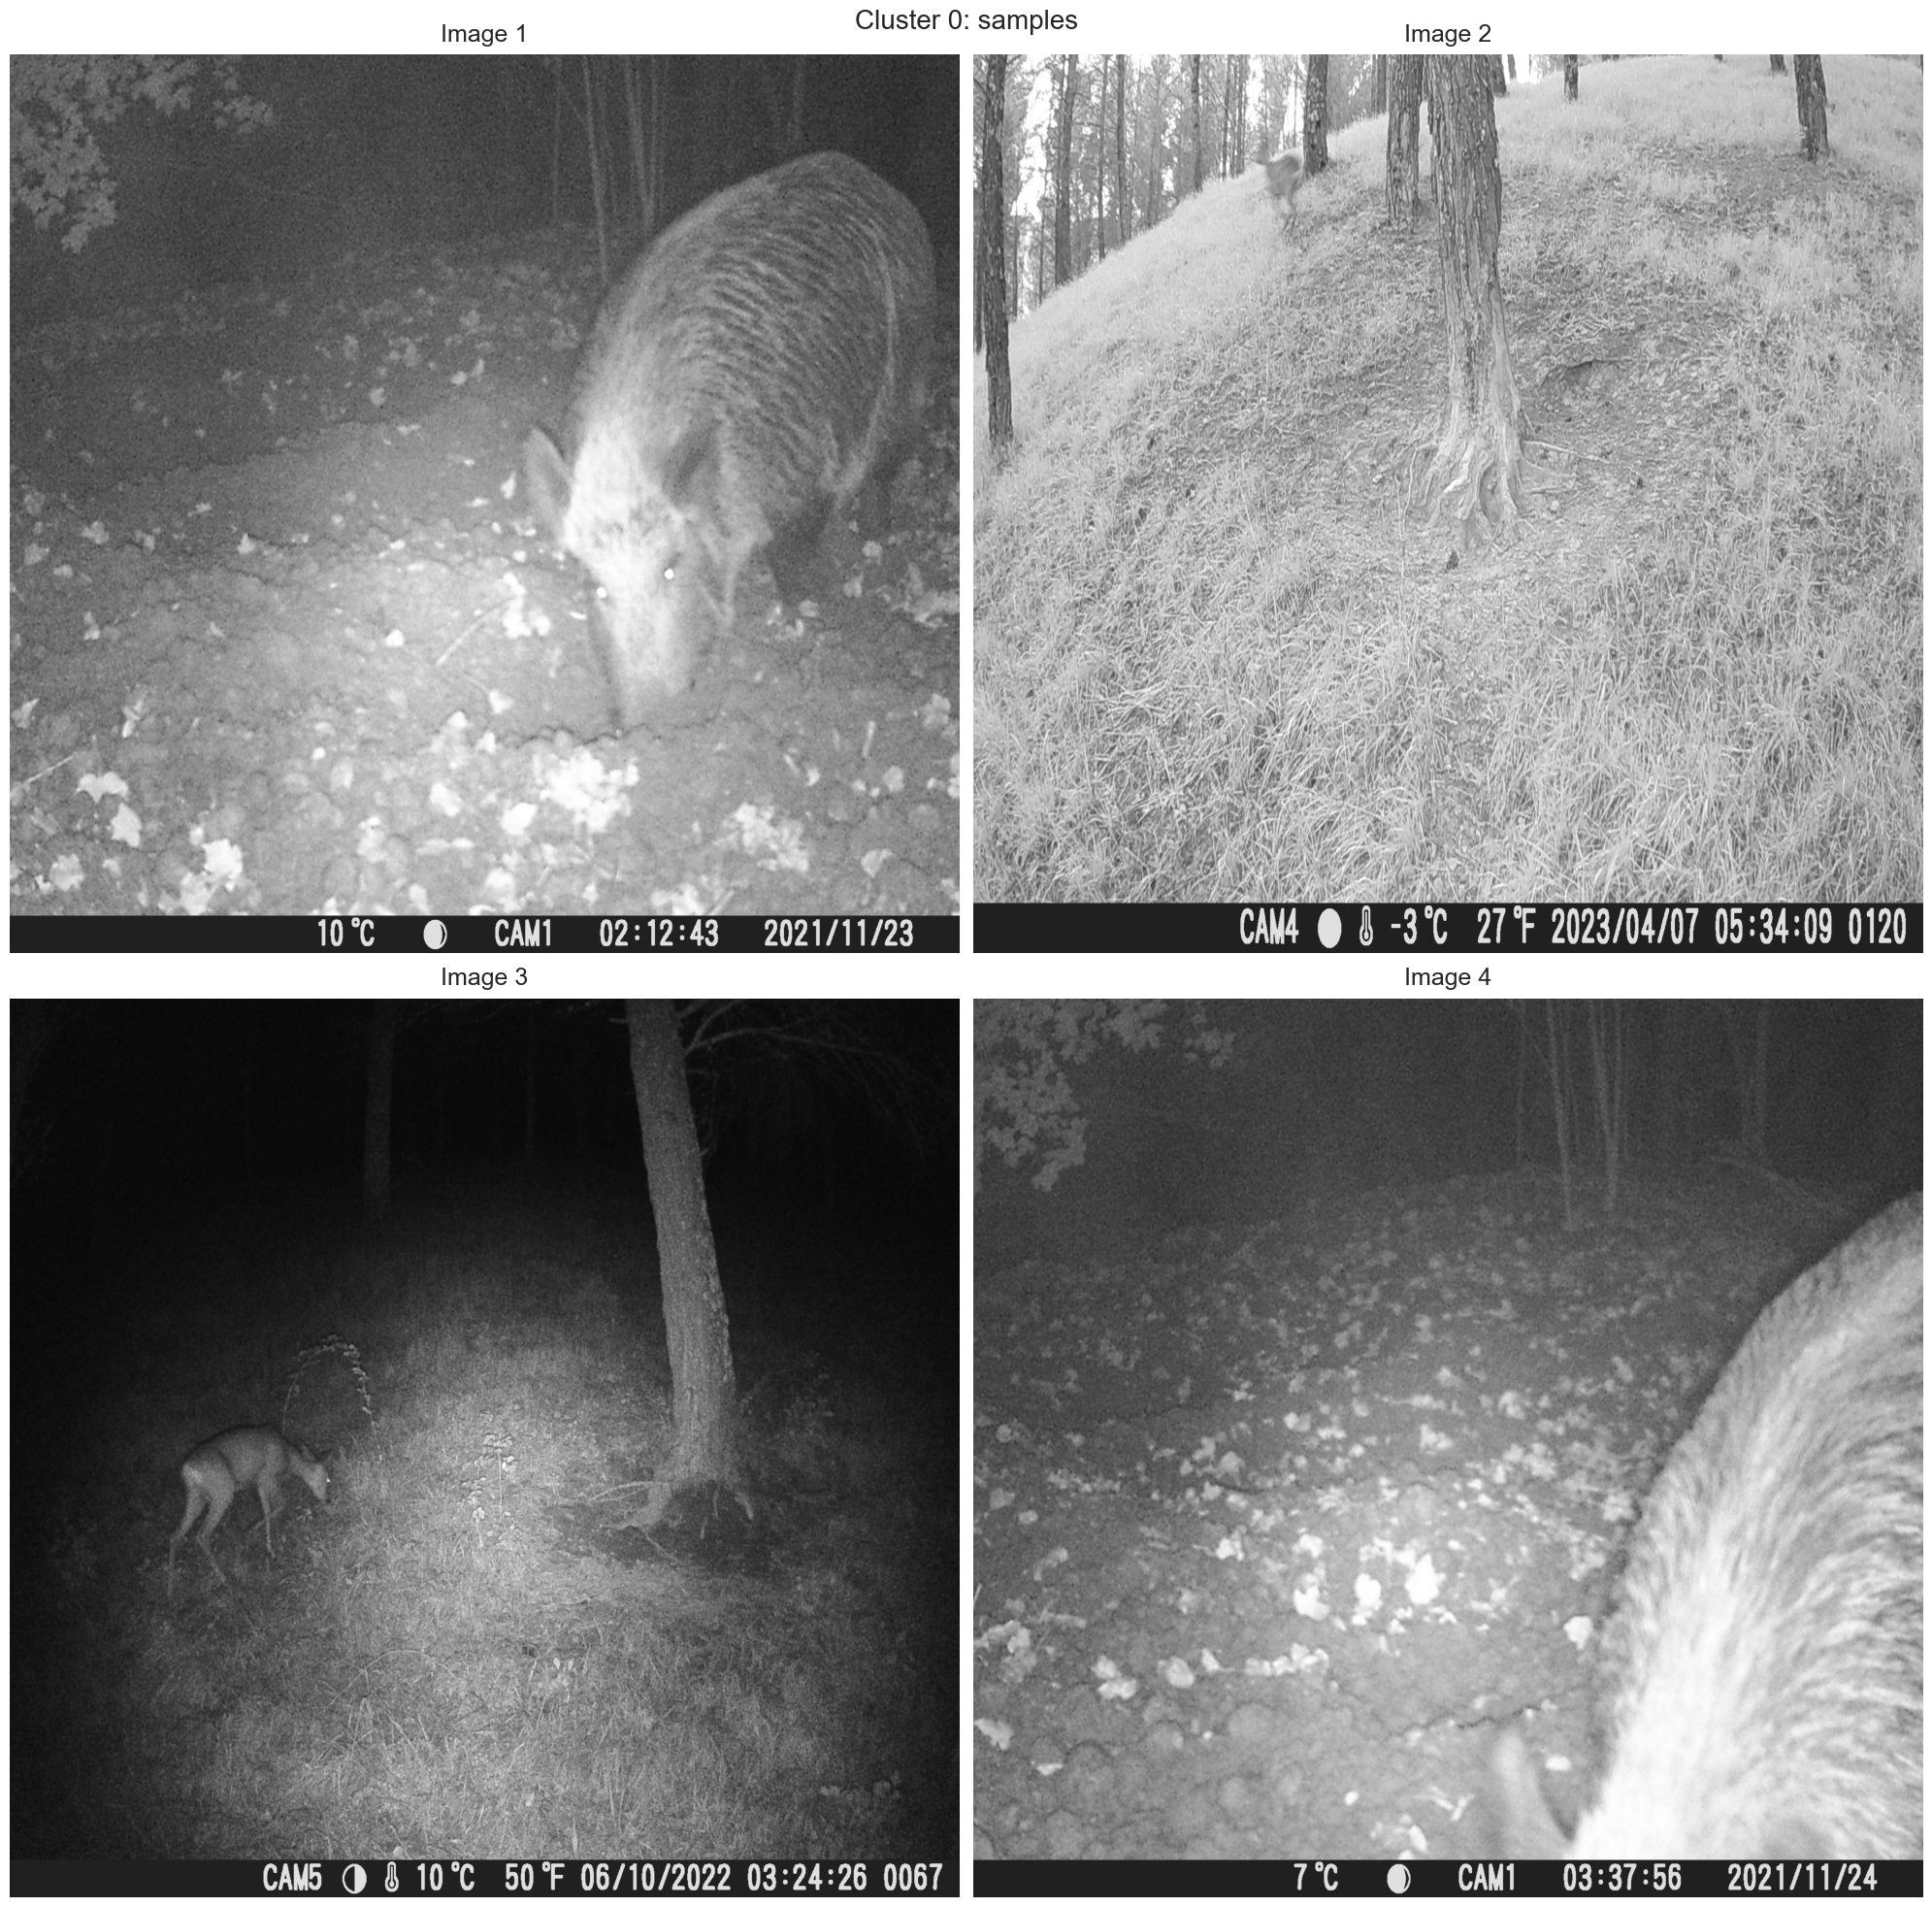

In [46]:
def plot_images_for_cluster(df, cluster, num_images=4):
    cluster_images = df[df['cluster'] == cluster]['image_name'].sample(num_images)

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            image_name = cluster_images.iloc[i]
            image_path = os.path.join(images_dir, image_name)
            image = Image.open(image_path)

            ax.imshow(image, aspect='auto')
            ax.axis('off')
            ax.set_title(f"Image {i + 1}", fontsize=18, pad=10)

    fig.suptitle(f"Cluster {cluster}: samples", fontsize=20)
    plt.tight_layout()
    plt.show()

# Example: Plot four images for Cluster 0
plot_images_for_cluster(df, cluster=0, num_images=6)

In [30]:
# saving the last version of the dataset
df.drop(columns=['date', 'time'], inplace=True)
df.rename(columns={'sha-256': 'sha256', 'temp': 'temperature', 'moon': 'moon_phase', 'camera': 'hunter_camera'}, inplace=True)

In [31]:
df.head()

image_name  hunter_camera            date_time  \
0   TF_ACULEI_8040_DSCF0129.jpg            1.0  2021-07-22 23:04:07   
1    TF_ACULEI_900_DSCF0756.jpg            1.0  2021-05-27 22:01:44   
2  TF_ACULEI_15294_DSCF0133.jpg            6.0  2023-03-30 20:35:58   
3  TF_ACULEI_11374_DSCF0064.jpg            6.0  2022-06-09 21:29:59   
4   TF_ACULEI_4106_DSCF4336.jpg            1.0  2021-06-16 23:41:09   

       moon_phase  temperature  \
0       Full Moon         25.0   
1       Full Moon         16.0   
2   First Quarter          9.0   
3  Waxing Gibbous         15.0   
4   First Quarter         19.0   

                                              sha256     label1     label2  \
0  00917733a6aa7e574a2da861dc75b70f5e38db45b50983...  wild boar        NaN   
1  01b46bf7f72f5ecd35669d876892619192c50771d44949...  wild boar        NaN   
2  a4080d64cc86785ee8ab82468db78b14e4ddb9838faef6...  porcupine     badger   
3  314a99154f1709a8a6ac99069b1af4cebf0cc9df089ce4...        fox  porcupine   
4  f1c6a3c629f9fb55975f6e02eeeccbd708477ddcf574e5...        fox       None   

      label3  cluster  
0        NaN        3  
1        NaN        3  
2        fox        5  
3  wild boar        2  
4       None        2

In [32]:
df.to_csv(csv_dir + "/aculei-clustered.csv")

In [33]:
# for cluster_label in df['cluster'].unique():
    
#     directory_path = f'./clusters/cluster-{cluster_label}'
#     os.makedirs(directory_path, exist_ok=True)
    
#     cluster_images = df[df['cluster'] == cluster_label]['image_name']
    
#     for image_name in cluster_images:
#         source_image_path = f'{images_dir}/{image_name}'
#         destination_image_path = f'{directory_path}/{image_name}'
        
#         shutil.copyfile(source_image_path, destination_image_path)